In [1]:
#imports
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN
from sklearn import metrics 
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.manifold import TSNE
from umap import UMAP
import scikitplot as skplot

import folium
import folium.plugins

# color maps
from matplotlib import cm

# for distance and h-clustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist, squareform


# sklearn does have some functionality too, but mostly a wrapper to scipy
from sklearn.metrics import pairwise_distances 
from sklearn.preprocessing import StandardScaler

pd.options.display.max_columns = None

## Data Cleaning

In [2]:
# df = pd.read_csv('melb_data.csv')
df = pd.read_csv('/Users/jeffrey/Documents/Boston University/BU-QST-Masters/Spring 2020/BA820/Team project/melb_data.csv')
df.head(5)

# df.shape


,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,3.0,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


In [3]:
#data types of each feature 
df.dtypes

# checking for null values
df.isnull().sum()

# converting the date column to 'datetime'
# the dataset consists of housing sales between 2016-2017
df['Date'] = pd.to_datetime(df['Date'])

#creating columns for the date and month the apartment was sold 
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

import calendar
df['Month'] = df['Month'].apply(lambda x: calendar.month_abbr[x])

#real estate count per year and month
df.groupby(['Year', 'Month'])['Year'].count()

#dropping columns of no significance
df.drop(columns=['YearBuilt', 'Postcode', 'Address'], inplace=True)

#filling null values for council area with 'unavailable'
df['CouncilArea'] = df.CouncilArea.fillna('Unavailable')

#dropping observations with null values for car
df.dropna(subset=['Car'], inplace=True)

df.groupby(['BuildingArea', 'Suburb'])['Suburb'].count()

df.describe()

#minimum price value is $85000 and maximum value is $9000000
#removing outliers (top and bottom 1 percentiles) for price and property count 
columns_list = ['Price','Propertycount']

for i in columns_list:
  print(i)
  df = df[(df[i] < np.percentile(df[i],99.5)) & (df[i] > np.percentile(df[i], 1))]
  print(df[i].describe())

# df = df[(df['Price'] < np.percentile(df['Price'],99.5)) & (df['Price'] > np.percentile(df['Price'], 1))]

df[df['Bathroom'] == 0].count()

df[df['Bedroom2'] == 0].count()

#removing observations with bathroom and bedroom values equal to 0
df = df[(df['Bedroom2'] != 0) & (df['Bathroom'] != 0)]

df.columns

Price
count    1.329700e+04
mean     1.064641e+06
std      5.763645e+05
min      3.010000e+05
25%      6.510000e+05
50%      9.050000e+05
75%      1.325000e+06
max      3.860000e+06
Name: Price, dtype: float64
Propertycount
count    12808.000000
mean      7138.232042
std       3715.017497
min        852.000000
25%       4380.000000
50%       6543.000000
75%       9264.000000
max      17496.000000
Name: Propertycount, dtype: float64


Index(['Suburb', 'Rooms', 'Type', 'Price', 'Method', 'SellerG', 'Date',
       'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea',
       'CouncilArea', 'Lattitude', 'Longtitude', 'Regionname', 'Propertycount',
       'Year', 'Month'],
      dtype='object')

<AxesSubplot:>

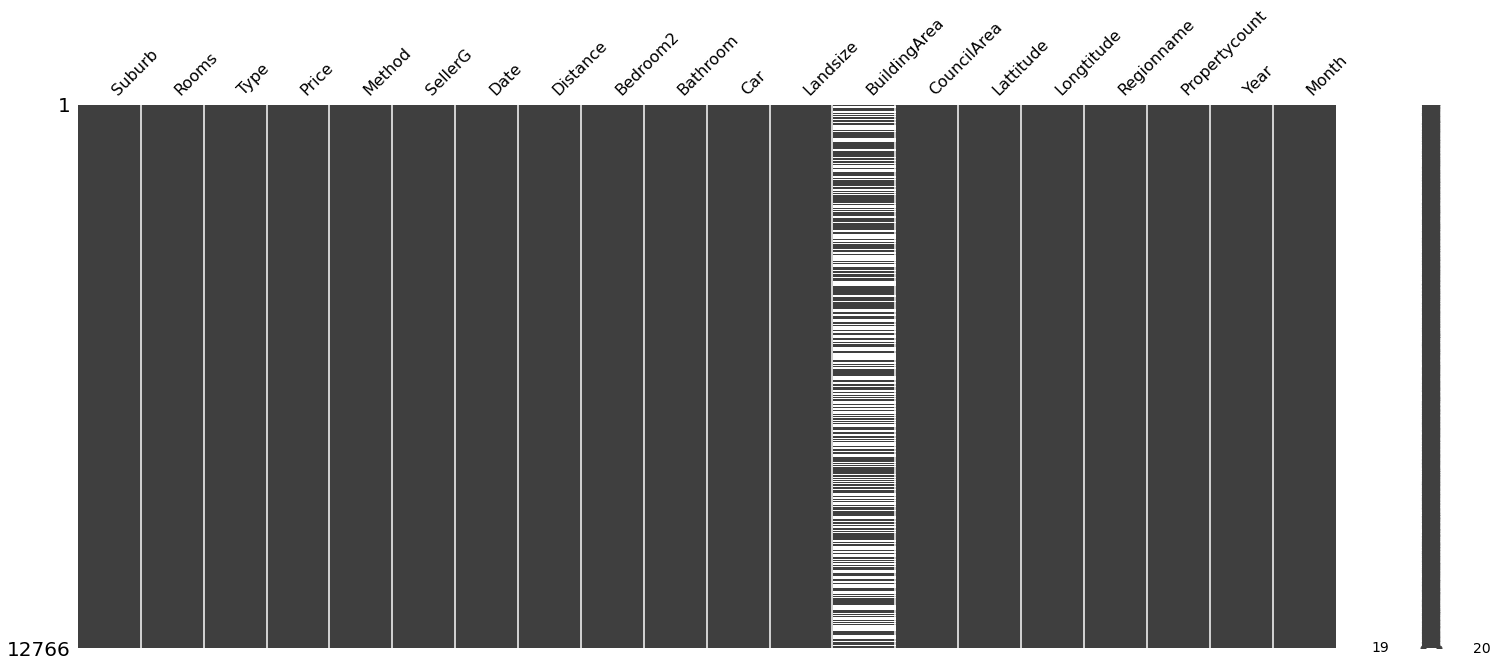

In [4]:
# Check missing values
msno.matrix(df)

## EDA

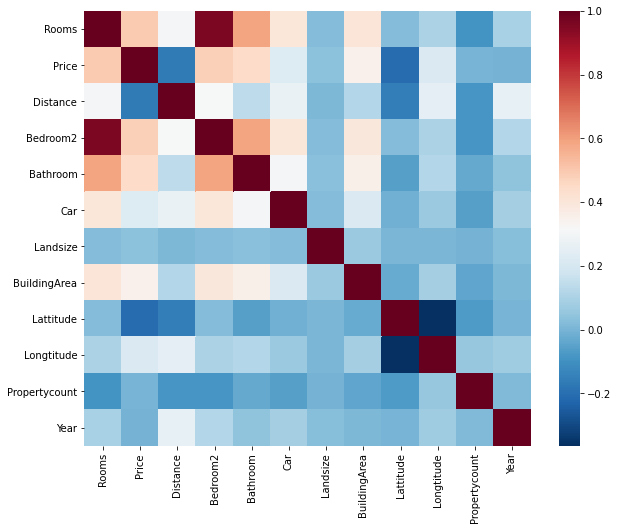

In [5]:
# Correlation Heatmap

plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), cmap='RdBu_r')
plt.show()

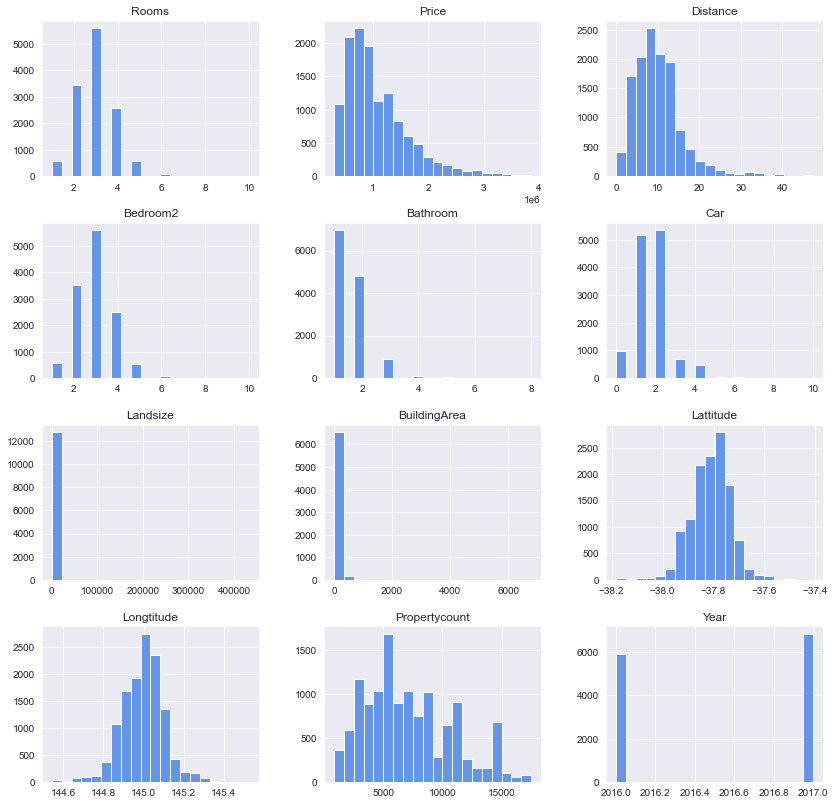

In [7]:
# Histogram of features

sns.set_style("darkgrid")
df.hist(figsize = (14,14), bins = 20, color="cornflowerblue")
plt.show()

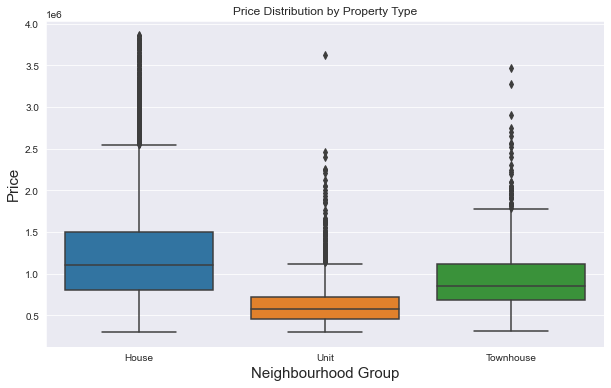

In [9]:
# Violinplots - showcase density and distribtuion of prices 

types = ['House', 'Unit', 'Townhouse']
plt.figure(figsize=(10,6))
ax = sns.boxplot(y="Price",x ='Type' ,data = df)
ax.set_xticklabels(types)
plt.title("Price Distribution by Property Type")
plt.xlabel('Neighbourhood Group',fontsize=15)
plt.ylabel("Price",fontsize=15);

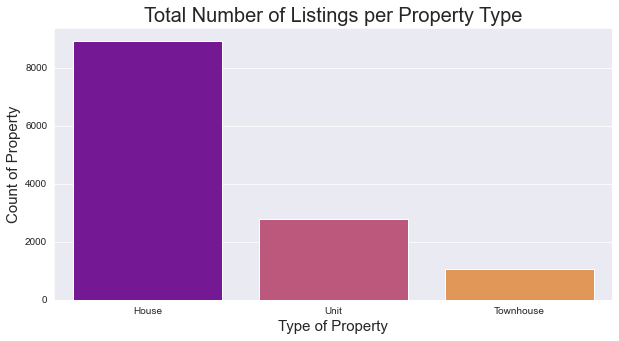

In [10]:
# Looking at how the quantity of each property type

ax = sns.countplot(x=df['Type'], palette="plasma")
ax.set_xticklabels(types)
fig = plt.gcf()
fig.set_size_inches(10,5)
plt.title('Total Number of Listings per Property Type',fontsize = 20)
plt.xlabel('Type of Property',fontsize = 15)
plt.ylabel('Count of Property',fontsize = 15)
plt.tick_params(labelsize=10)

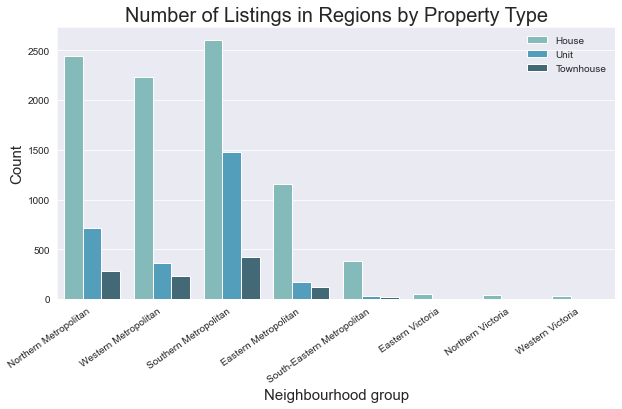

In [11]:
# Neighbourhoods and their property type count

plt.figure(figsize=(10,5))
sns.countplot(data=df, x='Regionname', hue='Type', palette='GnBu_d')
plt.title('Number of Listings in Regions by Property Type', fontsize=20)
plt.xlabel('Neighbourhood group',fontsize=15)
plt.ylabel("Count",fontsize=15)
plt.legend(frameon=False, fontsize=10,labels=types, loc="upper right")
plt.xticks(rotation=35, ha="right")
plt.tick_params(labelsize=10)

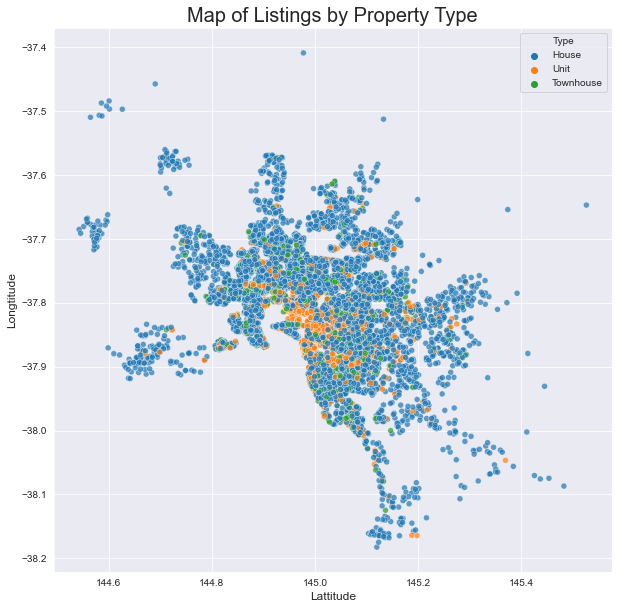

In [108]:
# Plotting the properties by latitude and longitude
data = df.copy()
data['Type'] = data['Type'].map({'h': 'House', 'u': 'Unit', 't':'Townhouse'})
plt.figure(figsize=(10,10))
a = sns.scatterplot(data=data, x='Longtitude', y='Lattitude', hue='Type', alpha=0.7, legend='full')
plt.title('Map of Listings by Property Type', fontsize=20)
plt.xlabel('Lattitude',fontsize=12)
plt.ylabel("Longtitude",fontsize=12)
# plt.legend(frameon=False, fontsize=13,labels=types, loc="upper right")
plt.tick_params(labelsize=10)

In [13]:
# Display heatmap on map of melbourne.

my_heatmap = folium.Map(location=[37.8136,144.9631], zoom_start=8)

heat_data = [[row['Lattitude'],row['Longtitude']] for index, row in df.iterrows()]

# Plot it on the map
folium.plugins.HeatMap(heat_data, min_opacity = 0.6, blur=30).add_to(my_heatmap)

# Display the map
sw = df[['Lattitude', 'Longtitude']].min().values.tolist()
ne = df[['Lattitude', 'Longtitude']].max().values.tolist()
my_heatmap.fit_bounds([sw, ne]) 
my_heatmap

In [14]:
#MarkerCluster

map2= folium.Map(location=[37.8136,144.9631], zoom_start=5, tiles='Stamen Terrain')

marker_cluster = folium.plugins.MarkerCluster().add_to(map2)
for index,row in df.iterrows():
  lat = row["Lattitude"]
  lon = row["Longtitude"]
  name = row['Regionname']

sw = df[['Lattitude', 'Longtitude']].min().values.tolist()
ne = df[['Lattitude', 'Longtitude']].max().values.tolist()

map2.fit_bounds([sw, ne]) 
folium.Marker([lat,lon],popup=name).add_to(marker_cluster)
map2

## Data Processing

In [15]:
df.head(3)

,Suburb,Rooms,Type,Price,Method,SellerG,Date,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,Year,Month
0,Abbotsford,2,h,1480000.0,S,Biggin,2016-03-12,2.5,2.0,1.0,1.0,202.0,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0,2016,Mar
1,Abbotsford,2,h,1035000.0,S,Biggin,2016-04-02,2.5,2.0,1.0,0.0,156.0,79.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0,2016,Apr
2,Abbotsford,3,h,1465000.0,SP,Biggin,2017-04-03,2.5,3.0,2.0,0.0,134.0,150.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0,2017,Apr


In [93]:
numeric = df.select_dtypes('number').copy()
del numeric['Year']
del numeric['BuildingArea']

In [94]:
numeric.head(3)

,Rooms,Price,Distance,Bedroom2,Bathroom,Car,Landsize,Lattitude,Longtitude,Propertycount
0,2,1480000.0,2.5,2.0,1.0,1.0,202.0,-37.7996,144.9984,4019.0
1,2,1035000.0,2.5,2.0,1.0,0.0,156.0,-37.8079,144.9934,4019.0
2,3,1465000.0,2.5,3.0,2.0,0.0,134.0,-37.8093,144.9944,4019.0


In [95]:
## Scaling
scaler = StandardScaler()
scaler.fit(numeric)
scaled = scaler.transform(numeric)
scaled = pd.DataFrame(scaled, columns = numeric.columns)
scaled.head(3)

,Rooms,Price,Distance,Bedroom2,Bathroom,Car,Landsize,Lattitude,Longtitude,Propertycount
0,-1.012590,0.694153,-1.286942,-0.994126,-0.799880,-0.640264,-0.086251,0.155706,0.025488,-0.839423
1,-1.012590,-0.071395,-1.286942,-0.994126,-0.799880,-1.692615,-0.097725,0.050650,-0.021964,-0.839423
2,0.048108,0.668348,-1.286942,0.071271,0.667889,-1.692615,-0.103213,0.032930,-0.012474,-0.839423


In [30]:
## PCA

pca = PCA(.95)
pca.fit(scaled)
pcs = pca.transform(scaled)
comps = pca.components_
COLS = ["PC" + str(i) for i in range(1, len(comps)+1)]
loadings = pd.DataFrame(comps.T, columns=COLS, index=numeric.columns)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
Rooms,0.513147,-0.159007,-0.016987,-0.037285,0.048711,-0.222713,-0.064504,-0.284271
Price,0.353684,0.085251,0.541956,-0.005809,-0.219023,0.137797,0.099423,-0.258458
Distance,0.209000,0.231868,-0.706037,0.031354,0.187923,-0.185537,-0.149670,-0.020664
Bedroom2,0.511970,-0.158241,-0.027894,-0.036825,0.057617,-0.227614,-0.063098,-0.274743
Bathroom,0.418158,-0.063301,0.165467,-0.007224,0.011146,-0.107157,-0.133323,0.873476
Car,0.314942,-0.065584,-0.234056,0.013580,0.181795,0.872779,0.185371,0.026508
Landsize,0.027008,-0.014470,0.048128,0.996237,0.048009,-0.022886,-0.016110,-0.019559
Lattitude,-0.073761,-0.662541,-0.091219,0.001503,0.188120,-0.196532,0.643461,0.066454
Longtitude,0.149438,0.631501,-0.036883,0.014475,-0.091553,-0.173856,0.701379,0.076700
Propertycount,-0.056973,0.205849,0.335515,-0.057455,0.912015,-0.050777,-0.034643,-0.046209


In [60]:
categorical = df.select_dtypes(exclude='number').copy()

In [75]:
for i in list(categorical.columns):
    print(i + ": " + str(len(categorical[i].unique())))

Suburb: 295
Type: 3
Method: 5
SellerG: 267
Date: 58
CouncilArea: 32
Regionname: 8
Month: 12


In [31]:
categorical = df[['Type', 'Method', 'Regionname', 'Month']].copy()

In [42]:
cat_binary = pd.get_dummies(categorical)
cat_binary.drop(['Type_h', 'Method_PI', 'Regionname_Eastern Metropolitan', 'Month_Apr'], axis=1, inplace=True)

## Hierarchical Clustering

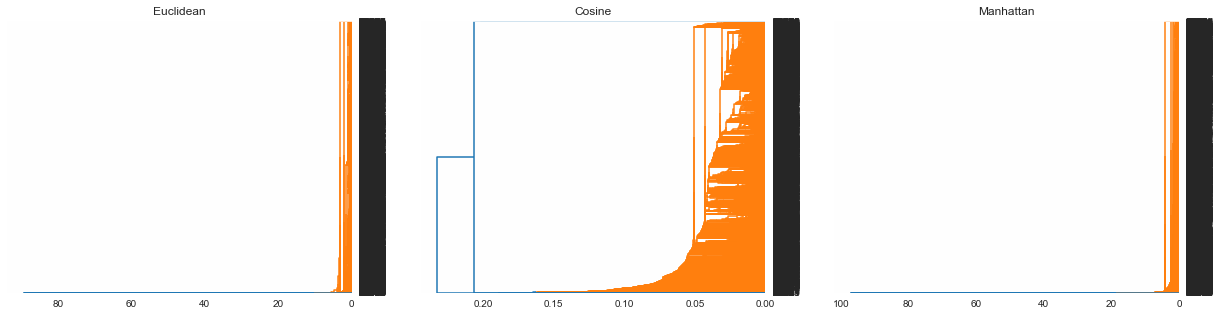

In [96]:
# Calculate distances
dist_euclidean = pdist(scaled.values)
dist_manhattan = pdist(scaled.values, metric = "cityblock") 
dist_cosine = pdist(scaled.values, metric = "cosine")

# Linkages
hclust_e = linkage(dist_euclidean)
hclust_c = linkage(dist_cosine)
hclust_m = linkage(dist_manhattan)

# Plot distance metrics
linkages = [hclust_e, hclust_c, hclust_m]
metrics = ['Euclidean', 'Cosine', 'Manhattan']
plt.figure(figsize = (21,5))
for i, m in enumerate(linkages):
    plt.subplot(1,3, i+1)
    plt.title(metrics[i])
    dendrogram(m,
              labels=scaled.index,
              leaf_font_size=10,
              orientation='left')

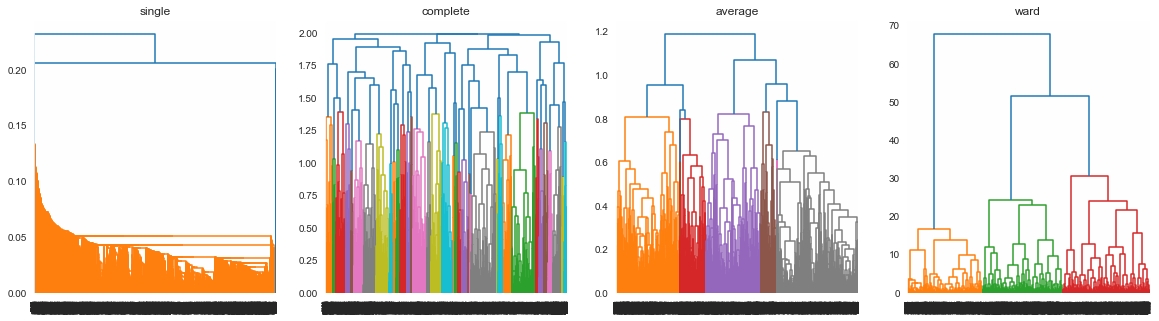

In [109]:
# Plot linkage methods for cosine
methods = ['single', 'complete', 'average', 'ward']
plt.figure(figsize = (20,5))
for i, m in enumerate(methods):
    plt.subplot(1, 4, i+1)
    plt.title(m)
    dendrogram(linkage(dist_cosine, method=m),
              leaf_rotation=90)

/Users/jeffrey/opt/miniconda3/envs/BA765/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


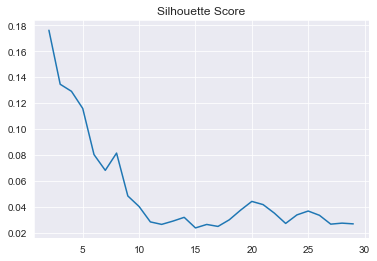

In [112]:
# Plotting silhouette scores
ks = range(2, 30)

silhouette = []

for k in ks:
    labs = fcluster(linkage(dist_cosine, method="complete"), k, criterion='maxclust')
    silhouette.append(silhouette_score(scaled, labs))

plt.title("Silhouette Score")
sns.lineplot(ks, silhouette)
plt.show()

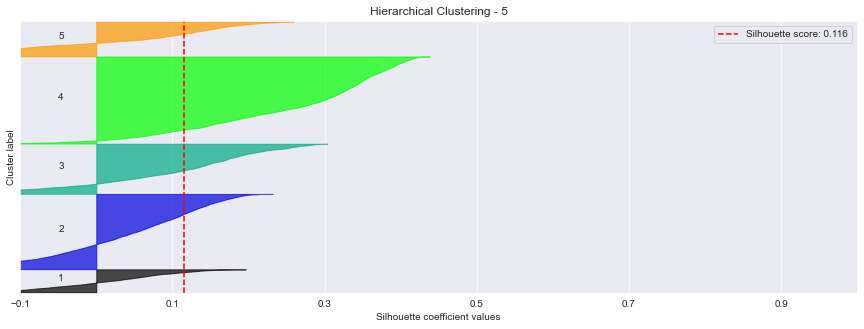

In [113]:
# Clustering 5 labels
labs = fcluster(linkage(dist_cosine, method="complete"), 5, criterion='maxclust')
df['cosine_complete_5'] = labs


skplot.metrics.plot_silhouette(scaled, labs, title="Hierarchical Clustering - 5", figsize=(15,5))
plt.show()

/Users/jeffrey/opt/miniconda3/envs/BA765/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/jeffrey/opt/miniconda3/envs/BA765/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


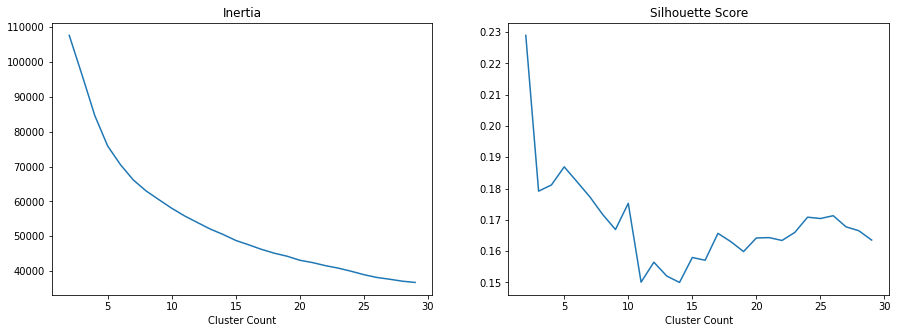

In [30]:
## KMeans

# Plotting inertia and silhouette
ks = range(2, 30)

inertia = []
silhouette = []

for k in ks:
    km = KMeans(k)
    km.fit(scaled)
    labels = km.predict(scaled)
    inertia.append(km.inertia_)
    silhouette.append(silhouette_score(scaled, labels))

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.title("Inertia")
sns.lineplot(ks, inertia)
plt.xlabel('Cluster Count')
plt.subplot(1, 2, 2)
plt.title("Silhouette Score")
sns.lineplot(ks, silhouette)
plt.xlabel('Cluster Count')
plt.show()

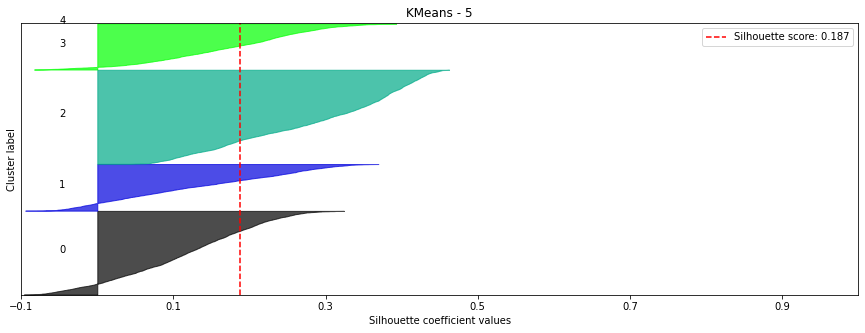

In [23]:
# Clustering for 6 labels
k5 = KMeans(5)
k5_labs = k5.fit_predict(scaled)

# Plotting Individual Cluster Silhouette Scores
skplot.metrics.plot_silhouette(scaled, k5_labs, title="KMeans - 5", figsize=(15,5))
plt.show()

In [24]:
df['kmeans_5'] = k5_labs

In [25]:
df.groupby("kmeans_5").mean()

,Rooms,Price,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,Lattitude,Longtitude,Propertycount,Year,cosine_complete_5
kmeans_5,,,,,,,,,,,,,
0,3.221691,8.609144e+05,11.321237,3.199952,1.483755,1.862876,561.322742,168.670663,-37.748674,144.921333,7158.132824,2016.564023,3.312470
1,4.103729,1.996376e+06,9.183583,4.074153,2.435919,2.189027,614.349764,234.451651,-37.825634,145.033117,7116.012002,2016.522503,4.748393
2,2.007655,7.852860e+05,6.614289,1.985329,1.119711,0.971508,391.632362,90.388419,-37.810609,144.984440,8131.051244,2016.440357,1.394642
3,3.152505,1.120638e+06,16.291242,3.130283,1.565142,1.869281,647.800871,154.605268,-37.899952,145.114068,6959.241830,2016.666667,3.471460
4,3.000000,2.700000e+06,2.100000,3.000000,3.000000,1.000000,433014.000000,NaN,-37.797510,144.983090,5825.000000,2017.000000,1.000000


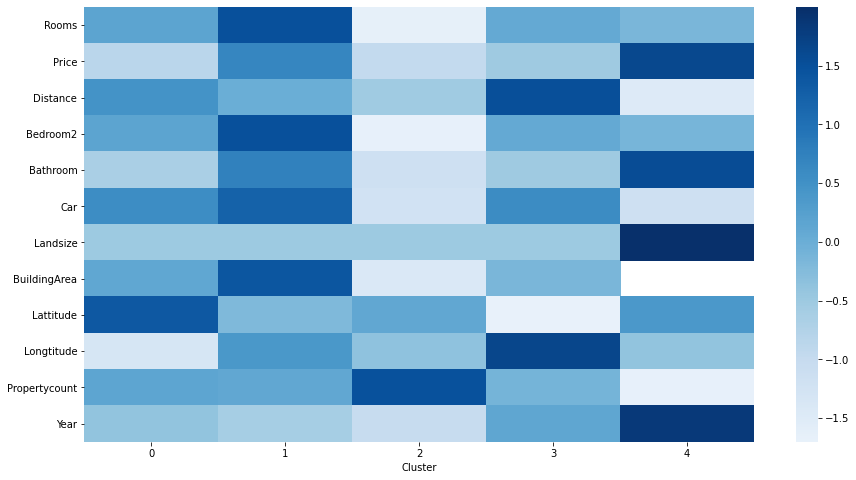

In [27]:
# Examining Cluster Means created with cosine metric and complete method
x = df.copy()
del x['cosine_complete_5']
cluster_profile = x.groupby('kmeans_5').mean()
cluster_profile.T

# Creating heatmap 
clust_scaler = StandardScaler()
cluster_scaled = clust_scaler.fit_transform(cluster_profile)

cluster_scaled = pd.DataFrame(cluster_scaled, 
                              index=cluster_profile.index, 
                              columns=cluster_profile.columns)

plt.figure(figsize=(15,8))
ax = sns.heatmap(cluster_scaled.T, cmap="Blues", center=0)
plt.xlabel('Cluster')
plt.show()

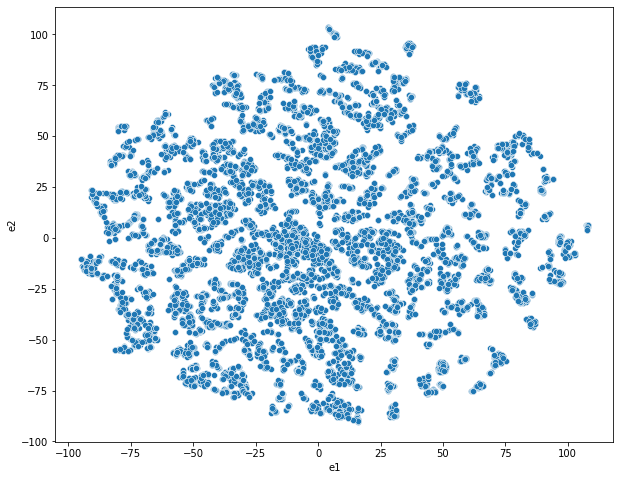

In [41]:
## TSNE

tsne = TSNE()
tsne.fit(pcs_m)

te = tsne.embedding_

tdata = pd.DataFrame(te, columns=["e1", "e2"])

PAL = sns.color_palette("bright", 10) 
plt.figure(figsize=(10, 8))
sns.scatterplot(x="e1", y="e2", data=tdata, legend="full", palette=PAL)
plt.show()

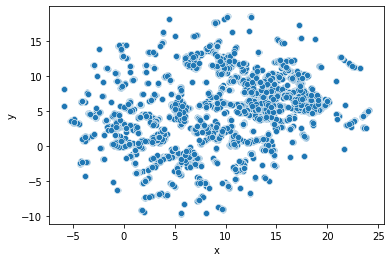

In [42]:
## UMAP

u = UMAP(random_state=820, n_neighbors=10)
u.fit(scaled)
ue = u.transform(scaled)

umap_df = pd.DataFrame(ue, columns=['x', 'y'])

sns.scatterplot(x="x", y="y", data=umap_df)
plt.figure(figsize=(10, 8))
plt.show()